In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import iscaxr as ixr
from iscaxr.plotting import plot_lat_lon, plot_lat_press, cmap, render_lat_lon_labels
import cartopy.crs as ccrs

# provides DataArray.in_units and DataArray.fft methods
from iscaxr import xarray_extensions


# The Effects of Numerical Damping on Large Scale Dynamics

## Spherical Harmonics

There are several options for numerical damping in Isca, all of which work by applying a damping mask to the vorticity and divergence fields.  The spectral core uses a basis of Spherical Harmonics
\begin{equation}
Y^m_l(\lambda, \phi) = P^m_l(\sin\phi)e^{im\lambda},
\end{equation}
where $P^m_l$ is the associated Legendre polynomial which can be calculated from a somewhat involved recursion relation.  Spherical harmonics are the eigenfunctions of Laplace's equation on a sphere of radius $a$, with associated eigenvalue $-l(l+1)$:
\begin{equation}
\nabla^2 Y^m_l = \frac{-l(l+1)}{a^2} Y^m_l.
\end{equation}

The Laplacian is a nice choice of basis for expansion as it is isotropic and can be defined in a coordinate independent manner.  Fourier modes are the natural basis of the Laplacian in a periodic cartesian domain, and to extend the idea to the surface of a sphere we must use spherical harmonics.  We can efficiently calculate an approximation to the real-valued field $psi$ using a trunctated sum of harmonics
\begin{equation}
\psi(\phi, \lambda) = \sum_{l=0}^L \sum_{m=-l}^l \hat\psi_{l,m} P^{m}_{l}(\sin\phi)e^{im\lambda} + \epsilon,
\end{equation}

where $\hat\psi_{l,m}$ are the complex spectral coefficients and $\epsilon$ is the truncation error.  For the sum of these linearly independent coefficients to be real, we require $\hat\psi_{l,-m} = \hat\psi_{l,m}^*$, where $^*$ denotes complex conjugation.

The "spherical wavenumber" is $l$. As can be seen from the defintion above, $m$ is the zonal wavenumber, the zonal structure represented by a Fourier component, $e^{im\lambda}$.  The meridional nodal number can be found from relation $n = l - m$.

For a series truncated to $l = L$, we choose to use a triangular truncation, so the largest meridional wavenumber is $M = L$ and keep all values of $m$ up to $L$.  The meridional wavenumber $n = L - m$ will change accordingly, so that for the highest zonal wavenumbers there will be little meridional structure. The total number of coefficients required in a triangular truncation is $(L + 1)^2$ (see figure below).

The nomenclature "T42" refers to the type of truncation (T for triangular, R for rhomboidal) and the largest zonal wavenumber "M = 42".

## Numerical Damping

At global scale resolutions we run the model (T42, T85 etc) we are not resolving the scale of the dissipative effects induced by viscosity, and so through nonlinear interactions we can see an accumulation of energy in the higher wavenumbers until our model becomes numerically unstable.  To combat this, we can introduce a damping scheme that aims to parameterise the effects of sub-grid scale dissipation.  

Isca has two such schemes: hyperviscosity and an exponential wavenumber cutoff.

### Hyperviscosity

Hyperviscosity uses the bi-harmonic Laplacian operator to introduce a scale dependent damping of the spectral coefficients.  Consider the time evolution of a field $u$ under the influence of forcing $F$ which includes non-linear effects and external forcings $S$
\begin{equation}
u_t = F(u, t, S). 
\end{equation}
Hyperviscosity amounts to adding a Laplacian term to the forcing,
\begin{equation}
u_t = F(u, t, S) + \nu\nabla^{2p}u,
\end{equation}
where $\nu$ is a viscosity coefficient and $p$ is the order of hyperviscosity.  So for $p=1$ we obtain natural diffusion, and for $p>1$,a higher order bi-harmonic term.

Roughly speaking, the spectral transform of this (Fourier in cartesian dimensions, spherical harmonics on the sphere) results in a tendency of the spectral coefficients like
\begin{equation}
\hat{u_t}_k = ... - \nu k^{p} \hat u_k,
\end{equation}
where $k^2$ is the eigenvalue of the two-dimensional series transform.  In the case of spherical harmonics, $k^2 = l(l+1)/a^2$.
The order of hyperviscosity therefore determines the scale dependence of the damping; the higher the value of $p$, the more heavily weighted the damping in the high wavenumbers becomes.

Isca has two options when defining hyperviscose numerical damping:  `resolution_dependent` and `resolution_independent`.  The informal description above corresponds to `resolution_independent`, as the damping of a given wavenumber will always be the same, regardless of total model resolution.  `resolution_dependent` scales the viscosity damping coefficient by the largest eigenvalue in the truncation, i.e.
\begin{equation}
\nu_{indep} = \frac{\nu}{(L(L+1))^{p}},
\end{equation}
so that the value of $\nu_{indep}$ specified in the model configuration as `spectral_dynamics_nml/damping_coeff` is the value of $\nu$ that applies at the grid scale, for whatever size grid you have defined.

### Exponential Cutoff Filter

The second method of damping is not based on a mathematical operator, but aims to achieve the same effect as hyperviscosity - to preferentially damp the energy accumulating at grid-scale wavenumbers.  A cut-off wavenumber, $k_c$, is chosen at which the filter becomes active.  All waves $k < k_c$ are not damped, where $k^2 = l(l+1)$.  The filter for waves $k > k_c$ is
\begin{equation}
D = \begin{cases} 
  \exp{\left( \ln(\nu\Delta t+1)  \left(- \frac{k - k_c}{K - k_c}    \right)^p \right)} & k \ge k_c, \\
  1 & k \lt k_c
  \end{cases}
\end{equation}
where normalising with $K^2 = L(L+1)$ in the denominator makes this somewhat analagous to the `resolution_dependent` formulation of hyperviscosity.  

(-3.5, 3.5)

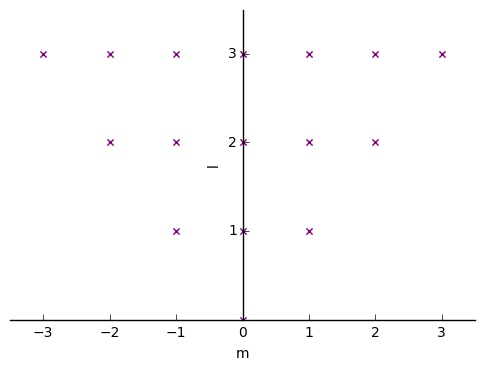

In [2]:
# plot the triangular trunctation

fig, ax = plt.subplots()

L = 3
l = np.arange(L)
m = np.arange(-L, L)



for l in range(L+1):
    m = np.arange(-l, l+1)
    ax.scatter(m, np.ones_like(m)*l, marker='x', color='purple')

ax.set_xlabel('m')
ax.set_ylabel('l')

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
#ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')


ax.set_yticks(np.arange(1,L+1))
ax.set_ylim(0, L+.5)
ax.set_xlim(-L-.5, L+.5)

## Experiments

We compare the effects of the different damping schemes on both the large scale and eddy dynamics in a standard Isca test case.  The experiment file `hyperdiff_comparison.py` used to run the simulations analysed in this notebook is included in the last cell of the notebook.

The test setup is:
* T85 resolution, 25 vertical levels.
* Frierson radiation scheme.
* Simple Betts-Miller radiation scheme.
* `damping_coefficient = 1.4e-4` ($\nu$ in the description above).  This is empirically derived as close to 10 days$^{-1}$ for the hyperdiffusive cases, and similar to the value used by Schneider and Liu (2015) for the exponential cutoff.

Numerical damping schemes tested:
1. Order 4 ($p=2$) hyperdiffusivity
2. Order 8 ($p=4$) hyperdiffusivity
3. Exponential cutoff ($p=4$), $k_c = 40$.


### Diagnostics

Daily diagnostics (snapshot) were output for the common data fields.  Hourly diagnostics were also produced for surface pressure $p_s$ to be used for higher resolution spectral analysis.


### Running

The model was run for 6 years with a timestep $\Delta t = 900s$


In [3]:
exp_attributes = [
    {'name': 'hyper_2',
     'label': '$\\nabla^4$',
     'directory': 'hyperdiff_comp_T85_hyper_2'
    },
    {'name': 'hyper_4',
     'label': '$\\nabla^8$',
     'directory': 'hyperdiff_comp_T85_hyper_4'
    },
    {'name': 'exp_cutoff',
     'label': 'exp[k$_{cutoff}$=40]',
     'directory': 'hyperdiff_comp_T85_exp_cutoff_4'
    },
]


In [4]:
exps = []
path = '/scratch/jp492/gfdl_data/%s/run0006/daily.nc'
for attrs in exp_attributes:
    e = xr.open_dataset(path % attrs['directory'], decode_times=False)
    e.attrs.update(attrs)  # xarray objects have an attributes dictionary.  add our labels etc to it
    exps.append(e)

# just open one hourly dataset - for comparison with 
hr = xr.open_dataset('/scratch/jp492/gfdl_data/%s/run0006/hourly.nc' % exps[2].directory, decode_times=False)
e.coords

Coordinates:
  * lon      (lon) float64 0.0 1.406 2.812 4.219 5.625 7.031 8.438 9.844 ...
  * lonb     (lonb) float64 -0.7031 0.7031 2.109 3.516 4.922 6.328 7.734 ...
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 -83.34 -81.94 -80.54 ...
  * latb     (latb) float64 -90.0 -88.28 -86.87 -85.46 -84.06 -82.65 -81.25 ...
  * time     (time) float64 7.214e+05 7.214e+05 7.214e+05 7.214e+05 ...
  * phalf    (phalf) float64 0.0 6.165 12.71 22.59 35.74 51.68 69.74 89.34 ...
  * pfull    (pfull) float64 2.268 9.244 17.42 28.92 43.47 60.48 79.34 99.54 ...

## Basic Diagnostics

Check the basic diagnostics of the model runs

In [5]:
surf_int = ixr.domain.make_surf_integrator(e, radius=ixr.constants.Rad_earth)
surf_mean = lambda x: surf_int(x)/surf_int(1)

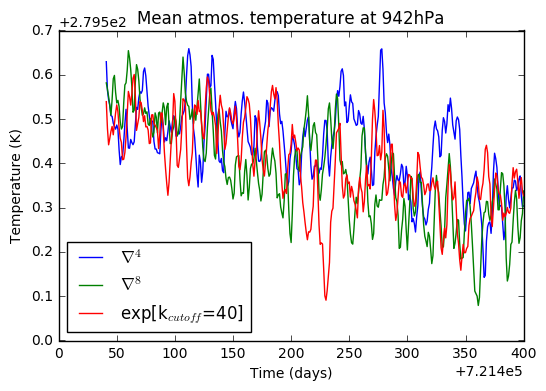

In [6]:
# plot the time evolution of mean surface temperature
fig, ax = plt.subplots()
for e in exps:
    e.temp.sel(pfull=e.pfull.max()).pipe(surf_mean).plot(label=e.label)
ax.legend(loc='lower left')
ax.set_title('Mean atmos. temperature at %dhPa' % e.pfull.max())
ax.set_ylabel('Temperature (K)')
ax.set_xlabel('Time (days)')

Perhaps not completely spun up, but close enough for the purposes of this comparison.

In [7]:
# Some useful levels and slices
# choose jet height: ~300hPa
p_jet = e.pfull.sel(pfull=300, method='nearest')
lat_eq = slice(-8,8)

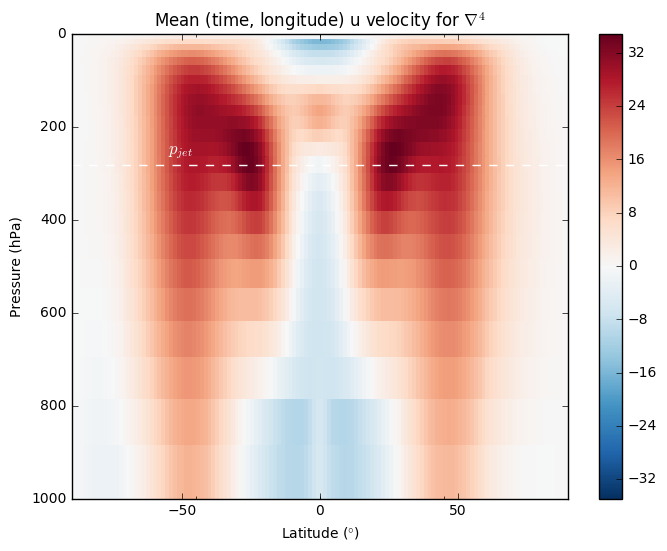

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
e = exps[0]
plot_lat_press(e.ucomp.mean(('time', 'lon')), e, ax=ax)
ax.hlines([p_jet], -90, 90, linestyle='--', color='white')
ax.text(-55, 260, '$p_{jet}$', color='white', fontsize=12)
ax.set_title('Mean (time, longitude) u velocity for {}'.format(e.label))

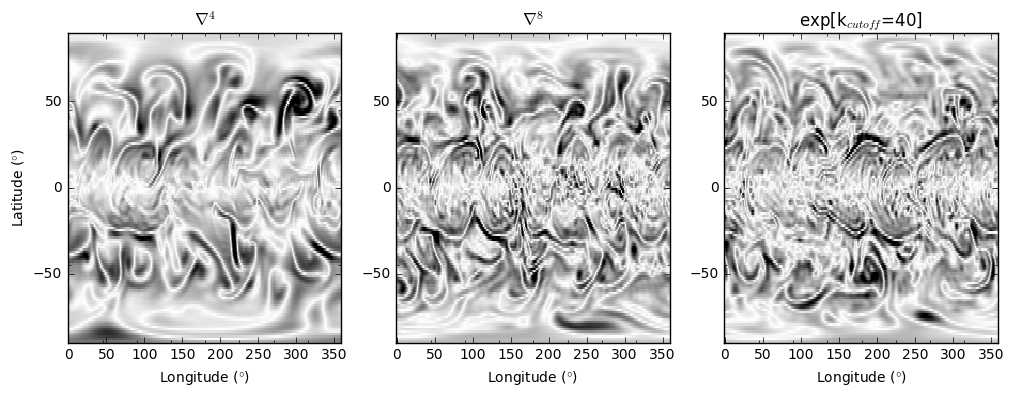

In [9]:
# compare vorticity fields at p_jet
fig, axs = plt.subplots(ncols=len(exps), figsize=(12, 4))
for e, ax in zip(exps, axs):
    pp = plot_lat_lon(e.vor.isel(time=-1).sel(pfull=p_jet), e, ax=ax, cmap=cmap.bwb)
    pp.set_clim(-1e-4, 1e-4)
    ax.set_title(e.label)
    render_lat_lon_labels(ax, e)
    if ax is not axs[0]:
        ax.set_ylabel('')
    

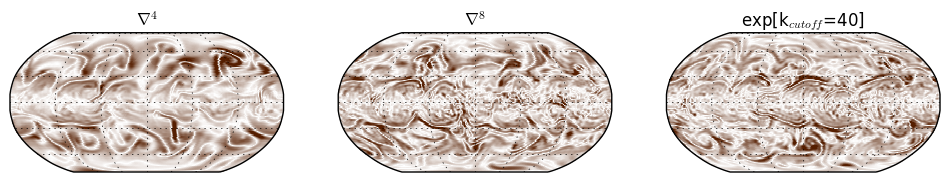

In [10]:
fig, axs = plt.subplots(ncols=len(exps), 
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, 
                        figsize=(12, 4))
for e, ax in zip(exps, axs):
    pp = plot_lat_lon(e.vor.isel(time=-1).sel(pfull=p_jet), e, ax=ax, cmap=cmap.BrWBr, overscale=0.6)
    pp.set_clim(-1e-4, 1e-4)
    ax.set_title(e.label)
    ax.gridlines()


## Comparative diagnostics

We now evaluate some diagnostics to examine the impact the damping scheme has on the large scale dynamics.

### Temperature

Equatorial lapse rate is essentially identical.


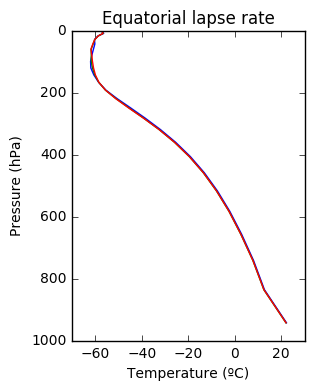

In [11]:
# Mean equatorial temperature profile
fig, ax = plt.subplots(figsize=(3, 4))
for e in exps:
    t_prof = e.temp.sel(lat=lat_eq).mean(('lat', 'lon', 'time')) - 273.
    ax.plot(t_prof, e.pfull, label=e.label)

ax.set_ylim(e.phalf.max(), e.phalf.min())
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel(u'Temperature (ºC)')
ax.set_title('Equatorial lapse rate')
#ax.legend(loc='lower left')

### Zonal mean zonal velocity

Considering the zonal flow (`ucomp`) at the surface and in the upper troposphere.

At the surface, the main difference is observed at the poles, where hyperdiffusivity results in a slightly weaker westward flow than the exponential cutoff, and a small poleward shift of the eastward maximum.

At the jet level (282hPa) we see a slight poleward shift of the eddy driven jet when using the $\nabla^4$ hyperviscosity.  I'm unsure why such large hemispheric assymetries exist in the annual mean flow!

In the stratos (192hPa), all three models exhibit superrotation above the equator, but it is most pronounced in the low order damping.

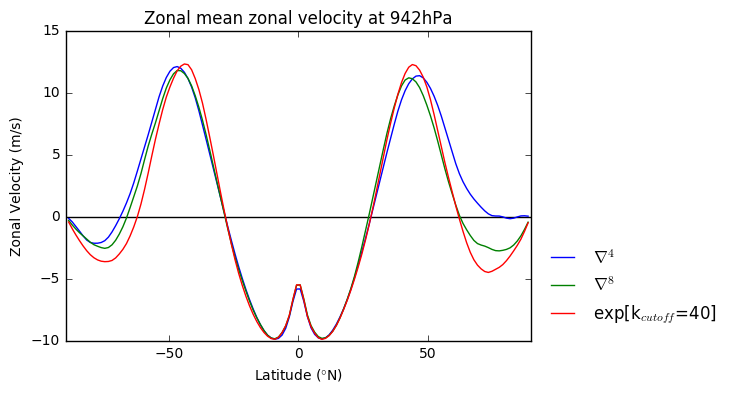

In [12]:
p = e.pfull.max()
for e in exps:
    e.ucomp.sel(pfull=p).mean(('time', 'lon')).plot(label=e.label)
leg = plt.legend(loc='lower left', frameon=True, bbox_to_anchor=(1,0))
leg.get_frame().set_linewidth(0.0)
plt.xlim(-90, 90)
plt.title('Zonal mean zonal velocity at {:d}hPa'.format(int(p)))
plt.xlabel('Latitude ($\\degree$N)')
plt.ylabel('Zonal Velocity (m/s)')
plt.hlines([0], -90, 90)

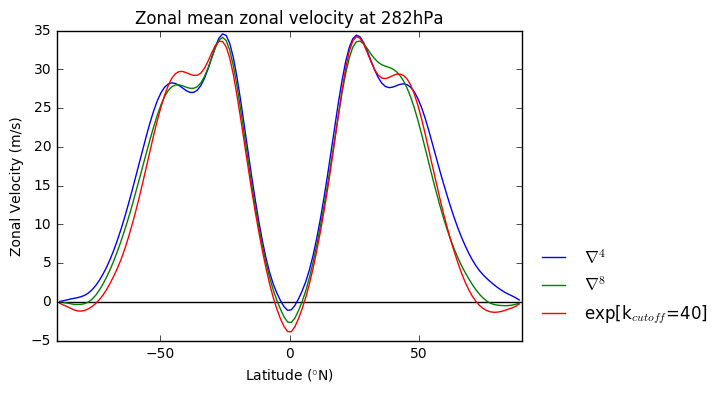

In [13]:
p = p_jet
for e in exps:
    e.ucomp.sel(pfull=p).mean(('time', 'lon')).plot(label=e.label)
leg = plt.legend(loc='lower left', frameon=True, bbox_to_anchor=(1,0))
leg.get_frame().set_linewidth(0.0)
plt.xlim(-90, 90)
plt.title('Zonal mean zonal velocity at {:d}hPa'.format(int(p)))
plt.xlabel('Latitude ($\\degree$N)')
plt.ylabel('Zonal Velocity (m/s)')
plt.hlines([0], -90, 90)

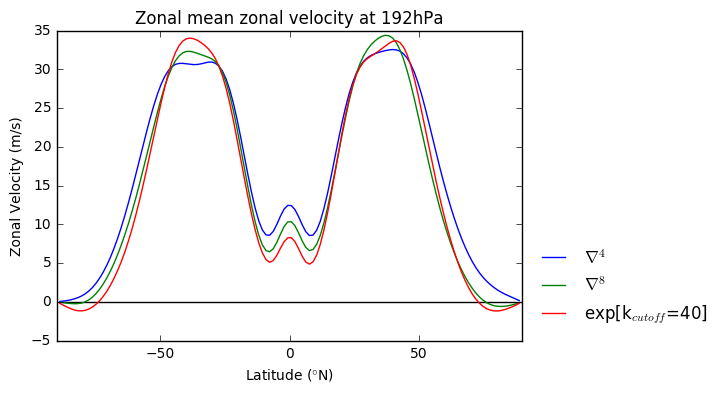

In [14]:
p = e.pfull.sel(pfull=180, method='nearest')
for e in exps:
    e.ucomp.sel(pfull=p, method='nearest').mean(('time', 'lon')).plot(label=e.label)
leg = plt.legend(loc='lower left', frameon=True, bbox_to_anchor=(1,0))
leg.get_frame().set_linewidth(0.0)
plt.xlim(-90, 90)
plt.title('Zonal mean zonal velocity at {:d}hPa'.format(int(p)))
plt.xlabel('Latitude ($\\degree$N)')
plt.ylabel('Zonal Velocity (m/s)')
plt.hlines([0], -90, 90)

### Eddy Momentum Flux

Mean (time, longitude) of the eddy momentum flux term $u'v'$. There may be a slight broadening of the signal with low order damping, but not significantly.

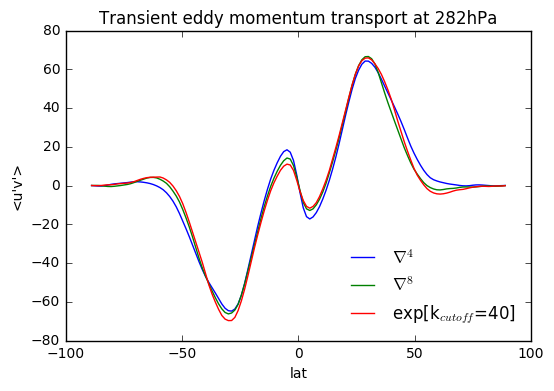

In [15]:
p = p_jet
#p = e.pfull.sel(pfull=e.pfull.max())
for e in exps:
    up = ixr.analysis.eddy(e.ucomp.sel(pfull=p))
    vp = ixr.analysis.eddy(e.vcomp.sel(pfull=p))

    (up*vp).mean(('time', 'lon')).plot(label=e.label)


leg = plt.legend(loc='lower right', frameon=True)
leg.get_frame().set_linewidth(0.0)
plt.ylabel("<u'v'>")
plt.title('Transient eddy momentum transport at %dhPa' % p)

## Spectral Analysis

We now consider a spectral decomposition of the flow.  Taking a latitudinal slice 40º-50ºN at 282hPa we take a Fourier transform in time and longitude and consider the absolute value of the spectral coefficients.
\begin{equation}
\hat\psi(\omega, k, \phi) = \mathcal{F}_{t, \lambda}[\psi(t, \lambda, \phi)]\\
\mathrm{Power}(\omega, k) = <\log(|\hat\psi|)>
\end{equation}
where $<>$ denotes a mean in latitude (assuming an $f$-plane).

We then plot the power spectrum as a $\omega-k$ space.  Straight lines in this space correspond to propgating waves, with a constant zonal phase speed.

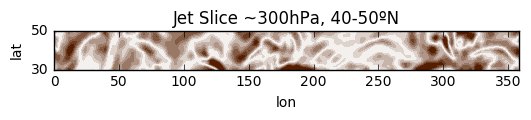

In [16]:
# choose a lat region around eddy maximum
lat_jet = slice(30,50)

fig, ax = plt.subplots(figsize=(6,.5))

(e.vor.sel(pfull=p_jet, lat=lat_jet)
 .isel(time=-1)
 .normalize()
 .plot.contourf(add_colorbar=False, cmap=cmap.BrWBr, levels=np.linspace(0.2, 0.8, 15), extend='both'))

ax.set_yticks([lat_jet.start, lat_jet.stop])
ax.set_title(u'Jet Slice ~300hPa, 40-50ºN')

In [17]:
def lpower(spectra):
    return np.log(np.abs(spectra))

def zonal_dispersion(field):
    f_t = field.fft(('time', 'lon'), scaledim=('time',)).pipe(lpower)
    # fourier transform in numpy is defined by exp(-2π i (kx + wt)) 
    # but we want exp(kx - wt) so need to negate one dimension
    f_t.values = f_t.values[::-1]
    f_t = f_t.rename({'F_time': 'freq', 'F_lon': 'k'})
    return f_t

R_earth = 6317e3  # [m]
day = 86400 # [s/day]
omega = 7.292e-5

def plot_kelvin(c, k=None, ax=None, R_earth=R_earth, **kwargs):
    """Plot a given wavespeed on a zonal dispersion diagram"""
    if ax is None:
        ax = plt.gca()
    
    if k is None:
        k = ax.get_xticks()

    cw = c/(R_earth*np.pi*2)  # [1/s]
    cwk = cw*day  # [1/day]

    ax.plot(k, k*cwk, **kwargs)

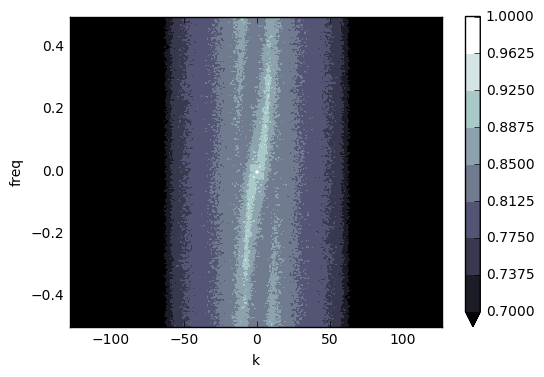

In [18]:
# calculate the full (symmetric) power spectrum of vorticity
# normalise to (0, 1) for easier plotting
(e.vor.sel(pfull=p_jet, lat=lat_jet)
 .pipe(zonal_dispersion)
 .mean('lat')
 .pipe(ixr.util.normalize)
 .plot.contourf(cmap=plt.cm.bone, levels=np.linspace(.7, 1, 9)))

### Spectral analysis of the vorticity in the jet stream

Marked lines denote waves of 7.5, 15 and 30m/s for reference.

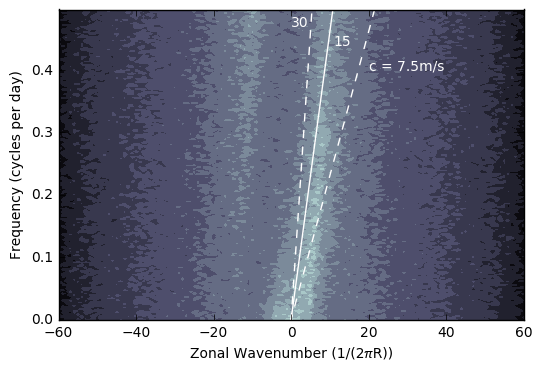

In [19]:
fig, ax = plt.subplots()

f_t = (e.vor
 .sel(pfull=p_jet, lat=lat_jet)
 .pipe(zonal_dispersion)
 .mean('lat'))

ax.contourf(f_t.k, f_t.freq, f_t.normalize(), cmap=plt.cm.bone, levels=np.linspace(0.7, 1.0, 11), extend='min')
ax.set_xlim(-60, 60)
ax.set_ylim(0, None)
plot_kelvin(15, ax=ax, color='white', linestyle='-', R_earth=ixr.constants.Rad_earth*np.cos(np.deg2rad(45)))
plot_kelvin(30, ax=ax, color='white', linestyle='--', R_earth=ixr.constants.Rad_earth*np.cos(np.deg2rad(45)))
plot_kelvin(7.5, ax=ax, color='white', linestyle='--', R_earth=ixr.constants.Rad_earth*np.cos(np.deg2rad(45)))

ax.text(0, 0.47, u'30', color='white')
ax.text(11, 0.44, u'15', color='white')
ax.text(20, 0.4, u'c = 7.5m/s', color='white')

ax.set_xlabel(u'Zonal Wavenumber (1/(2πR))')
ax.set_ylabel('Frequency (cycles per day)')

## Zonal wave power spectrum

Taking only the Fourier transform in the zonal dimension, calculating log power, and then taking the time and latitudinal mean, we can obtain a one-dimensional $k$-power spectrum.

For the transform of the zonal velocity, the vast majority of the power can be seen in the zonal mean component, $k=0$, as expected (note the log scale on y-axis).  Damping scheme does have a significant impact on the energy contained at smaller wavelengths, above $k\simeq15$.

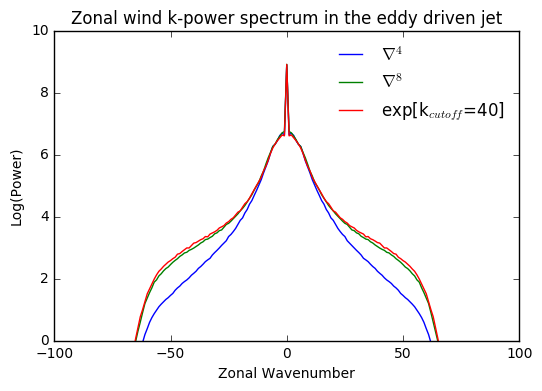

In [20]:
for e in exps:
    e.ucomp.sel(pfull=p_jet, lat=lat_jet).fft('lon').pipe(lpower).mean(('time', 'lat')).plot(label=e.label)
plt.legend(loc='upper right', frameon=False)
plt.xlim(-100, 100)
plt.ylim(0, 10)
plt.title('Zonal wind k-power spectrum in the eddy driven jet')
plt.xlabel('Zonal Wavenumber')
plt.ylabel('Log(Power)')

Here the same calculation is done for vorticity, which does not have the same peak in zonal mean. 

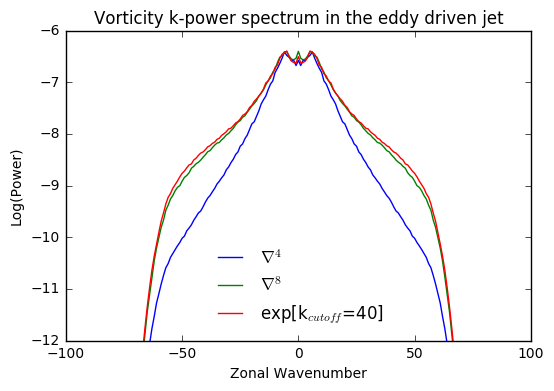

In [21]:
for e in exps:
    e.vor.sel(pfull=p_jet, lat=lat_jet).fft('lon').pipe(lpower).mean(('time', 'lat')).plot(label=e.label)
plt.legend(loc='lower center', frameon=False)
plt.xlim(-100, 100)
plt.ylim(-12, -6)
plt.title('Vorticity k-power spectrum in the eddy driven jet')
plt.xlabel('Zonal Wavenumber')
plt.ylabel('Log(Power)')

## High Temporal Resolution Spectra

There appears to be some time aliasing in the upper frequencies of the daily dispersion plane:

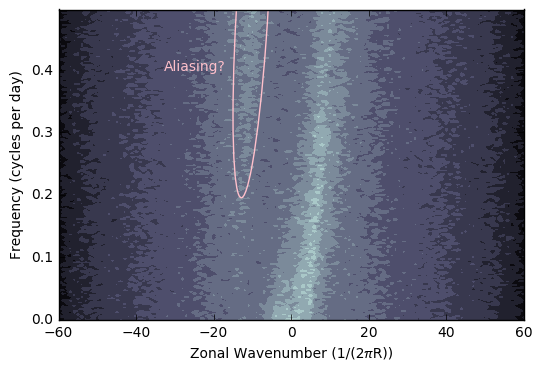

In [22]:
fig, ax = plt.subplots()
ax.contourf(f_t.k, f_t.freq, f_t.normalize(), cmap=plt.cm.bone, levels=np.linspace(0.7, 1.0, 11), extend='min')
ax.set_xlim(-60, 60)
ax.set_ylim(0, None)
ax.set_xlabel(u'Zonal Wavenumber (1/(2πR))')
ax.set_ylabel('Frequency (cycles per day)')

circ = matplotlib.patches.Ellipse((-10, 0.5), 10, 0.5, angle=2, facecolor='none', edgecolor='pink')
ax.add_patch(circ)
ax.text(-17, 0.4, 'Aliasing?', horizontalalignment='right', color='pink')

Perform the same analysis at higher temporal resolution, the aliasing is reduced, relative to the signal.

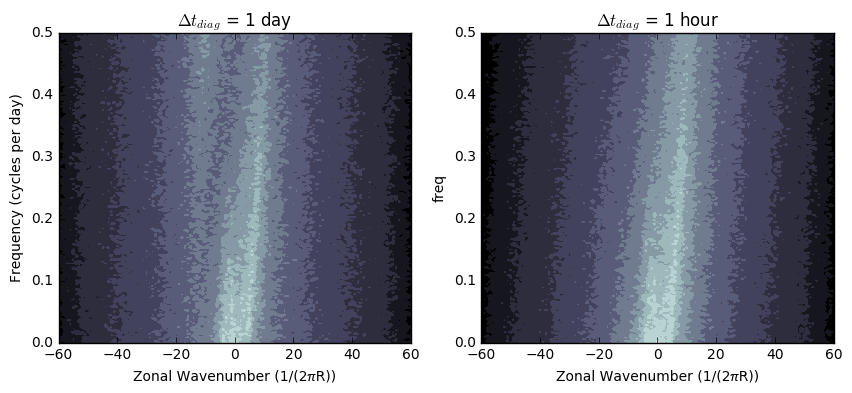

In [23]:
# high resolution timestamps are given in hours, but we want to compare cycles per day, so convert the time axis
hr['time'] = hr.time.in_units('day')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
plot_args = dict(cmap=plt.cm.bone, levels=np.linspace(0.5, 1.0, 11), extend='min', add_colorbar=False)

# remove the mean surface pressure, and plot the spectra of the eddies
(exps[2].ps.sel(lat=lat_jet)
     .pipe(ixr.analysis.eddy, dim=('time', 'lat', 'lon'))
     .pipe(zonal_dispersion)
     .mean('lat')
     .normalize()
     .plot.contourf(ax=ax1, **plot_args))

(hr.ps.sel(lat=lat_jet)
     .pipe(ixr.analysis.eddy, dim=('time', 'lat', 'lon'))
     .pipe(zonal_dispersion)
     .mean('lat')
     .normalize()
     .plot.contourf(ax=ax2, **plot_args))

for ax in (ax1, ax2):
    ax.set_xlim(-60, 60)
    ax.set_ylim(0, 0.5)
    ax.set_xlabel(u'Zonal Wavenumber (1/(2πR))')

ax1.set_ylabel('Frequency (cycles per day)')    
ax1.set_title(r'$\Delta t_{diag}$ = 1 day')
ax2.set_title(r'$\Delta t_{diag}$ = 1 hour')

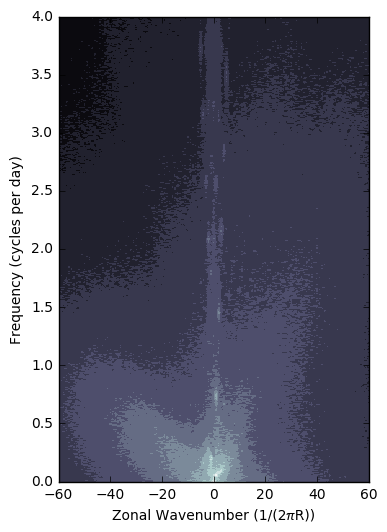

In [24]:
# full high resolution spectrum at the equator (symmetric component)
fig, ax = plt.subplots(figsize=(4, 6))

f_t = hr.ps.sel(lat=lat_eq).pipe(ixr.analysis.eddy, dim=('time', 'lat', 'lon')).pipe(zonal_dispersion).mean('lat').normalize()
ax.contourf(f_t.k, f_t.freq, f_t.normalize(), cmap=plt.cm.bone, levels=np.linspace(0.4, 1.0, 11), extend='min')

ax.set_xlim(-60, 60)
ax.set_ylim(0, 4)
ax.set_xlabel(u'Zonal Wavenumber (1/(2πR))')
ax.set_ylabel('Frequency (cycles per day)')
#plot_kelvin(c=30, ax=ax, color='white')

## Experiment file used to run the model

`hyperdiff_comparison.py`